# Vehicle model classification

### Import libraries

In [1]:
import os
import cv2
import copy
import time
import torch
import string
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime
from torchvision import models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms as T
from sklearn.metrics import classification_report

### Global variables

In [2]:
DATA_DIR_RAW = "../../../data/cars-dataset/"
DATA_DIR_RAW_TRAIN = f'{DATA_DIR_RAW}/train'
DATA_DIR_RAW_TEST = f'{DATA_DIR_RAW}/test'

RESIZE = (224, 224)

### Visualization and data preparation

In [3]:
def get_df(dir_path):
    image_list, class_list = [], []
    classes = os.listdir(dir_path)
    for class_member in classes:
        images = os.listdir(os.path.join(dir_path, class_member))
        for image in images:
            image_list.append(os.path.join(dir_path, class_member, image))
            class_list.append(class_member)
    df_dict = {
        "image": image_list,
        "class": class_list
    }
    return pd.DataFrame.from_dict(df_dict)

train_df, test_df = get_df(DATA_DIR_RAW_TRAIN), get_df(DATA_DIR_RAW_TEST)

In [4]:
train_df

,image,class
0,../../../data/cars-dataset//train/Tata Safari/...,Tata Safari
1,../../../data/cars-dataset//train/Tata Safari/...,Tata Safari
2,../../../data/cars-dataset//train/Tata Safari/...,Tata Safari
3,../../../data/cars-dataset//train/Tata Safari/...,Tata Safari
4,../../../data/cars-dataset//train/Tata Safari/...,Tata Safari
...,...,...
3347,../../../data/cars-dataset//train/Mahindra Sco...,Mahindra Scorpio
3348,../../../data/cars-dataset//train/Mahindra Sco...,Mahindra Scorpio
3349,../../../data/cars-dataset//train/Mahindra Sco...,Mahindra Scorpio
3350,../../../data/cars-dataset//train/Mahindra Sco...,Mahindra Scorpio


In [5]:
test_df

,image,class
0,../../../data/cars-dataset//test/Tata Safari/5...,Tata Safari
1,../../../data/cars-dataset//test/Tata Safari/2...,Tata Safari
2,../../../data/cars-dataset//test/Tata Safari/2...,Tata Safari
3,../../../data/cars-dataset//test/Tata Safari/2...,Tata Safari
4,../../../data/cars-dataset//test/Tata Safari/4...,Tata Safari
...,...,...
808,../../../data/cars-dataset//test/Mahindra Scor...,Mahindra Scorpio
809,../../../data/cars-dataset//test/Mahindra Scor...,Mahindra Scorpio
810,../../../data/cars-dataset//test/Mahindra Scor...,Mahindra Scorpio
811,../../../data/cars-dataset//test/Mahindra Scor...,Mahindra Scorpio


In [6]:
train_df["class"].unique()

array(['Tata Safari', 'Audi', 'Toyota Innova', 'Swift', 'Hyundai Creta',
       'Rolls Royce', 'Mahindra Scorpio'], dtype=object)

In [7]:
classes = sorted(list(train_df["class"].unique()))
CLASSES_TO_INT = {i: ind for ind, i in enumerate(classes)}
INT_TO_CLASSES = {v: k for k , v in CLASSES_TO_INT.items()}

In [8]:
CLASSES_TO_INT

{'Audi': 0,
 'Hyundai Creta': 1,
 'Mahindra Scorpio': 2,
 'Rolls Royce': 3,
 'Swift': 4,
 'Tata Safari': 5,
 'Toyota Innova': 6}

In [9]:
INT_TO_CLASSES

{0: 'Audi',
 1: 'Hyundai Creta',
 2: 'Mahindra Scorpio',
 3: 'Rolls Royce',
 4: 'Swift',
 5: 'Tata Safari',
 6: 'Toyota Innova'}

In [10]:
train_df["label"] = train_df["class"].apply(lambda x: CLASSES_TO_INT[x])
test_df["label"] = test_df["class"].apply(lambda x: CLASSES_TO_INT[x])

In [11]:
train_df

,image,class,label
0,../../../data/cars-dataset//train/Tata Safari/...,Tata Safari,5
1,../../../data/cars-dataset//train/Tata Safari/...,Tata Safari,5
2,../../../data/cars-dataset//train/Tata Safari/...,Tata Safari,5
3,../../../data/cars-dataset//train/Tata Safari/...,Tata Safari,5
4,../../../data/cars-dataset//train/Tata Safari/...,Tata Safari,5
...,...,...,...
3347,../../../data/cars-dataset//train/Mahindra Sco...,Mahindra Scorpio,2
3348,../../../data/cars-dataset//train/Mahindra Sco...,Mahindra Scorpio,2
3349,../../../data/cars-dataset//train/Mahindra Sco...,Mahindra Scorpio,2
3350,../../../data/cars-dataset//train/Mahindra Sco...,Mahindra Scorpio,2


In [12]:
test_df

,image,class,label
0,../../../data/cars-dataset//test/Tata Safari/5...,Tata Safari,5
1,../../../data/cars-dataset//test/Tata Safari/2...,Tata Safari,5
2,../../../data/cars-dataset//test/Tata Safari/2...,Tata Safari,5
3,../../../data/cars-dataset//test/Tata Safari/2...,Tata Safari,5
4,../../../data/cars-dataset//test/Tata Safari/4...,Tata Safari,5
...,...,...,...
808,../../../data/cars-dataset//test/Mahindra Scor...,Mahindra Scorpio,2
809,../../../data/cars-dataset//test/Mahindra Scor...,Mahindra Scorpio,2
810,../../../data/cars-dataset//test/Mahindra Scor...,Mahindra Scorpio,2
811,../../../data/cars-dataset//test/Mahindra Scor...,Mahindra Scorpio,2


In [13]:
def compute_class_weights(df, label_col="label"):
    class_weights = [0] * df[label_col].nunique()
    value_counts = sorted(df[label_col].value_counts().to_dict().items())
    total_count = len(df)
    for k, c in value_counts:
        class_weights[k] = c
    return torch.Tensor(class_weights).type(torch.float32)

CLASS_WEIGHTS = compute_class_weights(train_df)
CLASS_WEIGHTS

tensor([814., 271., 316., 311., 424., 441., 775.])

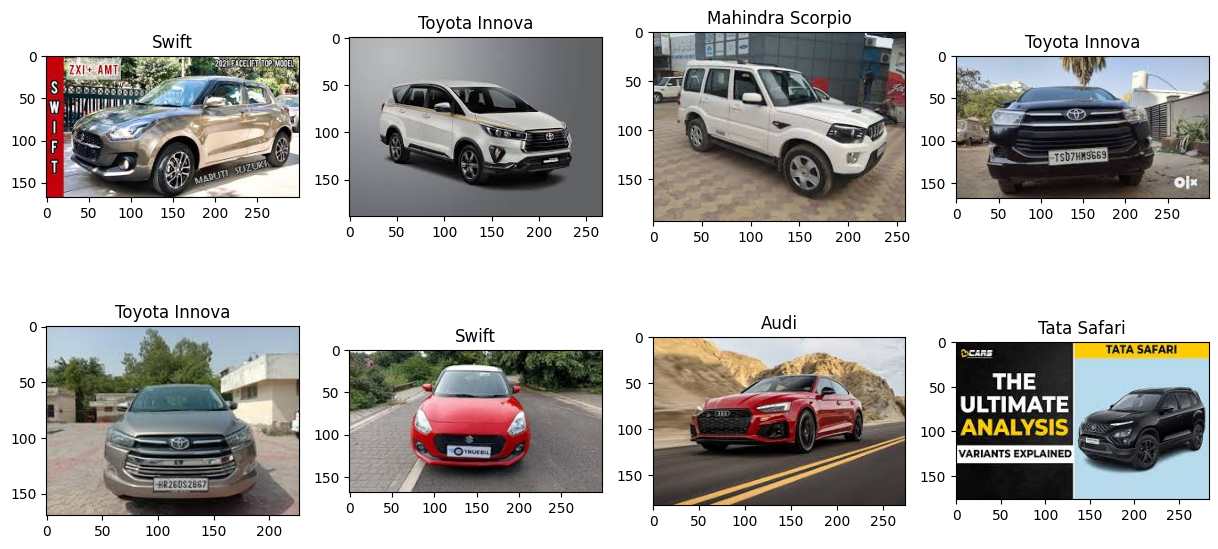

In [14]:
def visualize(df):
    sampled_df = df.sample(n=8)
    ptr = 0
    _, ax = plt.subplots(2, 4, figsize=(15, 7))
    for r in range(2):
        for c in range(4):
            image = cv2.imread(sampled_df.iloc[ptr]["image"])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            ax[r, c].imshow(image)
            ax[r, c].set_title(sampled_df.iloc[ptr]["class"])
            ptr += 1

visualize(train_df)

<Axes: >

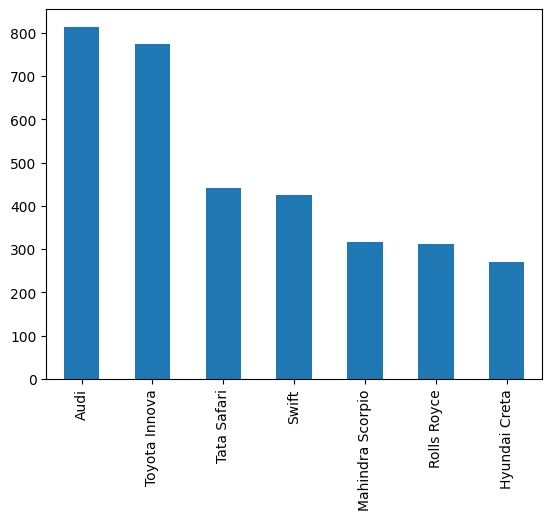

In [15]:
train_df['class'].value_counts().plot(kind='bar')

### Transforms

In [16]:
class Resize:

    def __init__(self, size = (224, 224)):
        assert isinstance(size, tuple), "`size` must be a tuple."
        assert isinstance(size[0], int) and isinstance(size[1], int), "`size` must be a tuple of integers."
        self.size = size
    
    def __call__(self, instance):
        new_height, new_width = self.size
        instance["image"] = np.asarray(instance["image"].resize((new_width, new_height)))
        return instance

    
class Normalize:
    
    def __init__(self, mean: tuple = (0.485, 0.456, 0.406), variance: tuple = (0.229, 0.224, 0.225)):
        self.mean = mean
        self.variance = variance

    def __call__(self, instance):
        image = instance["image"]
        image = image - np.array([self.mean[0]*255, self.mean[1]*255, self.mean[2]*255], dtype=np.float32)
        image = image / np.array([self.variance[0]*255, self.variance[1]*255, self.variance[2]*255], dtype=np.float32)
        image = np.clip(image, 0, 1).astype(np.float32)
        instance["image"] = image
        return instance

    
class ToTensor:

    def __call__(self, instance):
        instance["image"] = torch.permute(torch.from_numpy(np.array(instance["image"])).type(torch.float32), (2, 0, 1))
        instance["label"] = torch.tensor(instance["label"])
        return instance

### Dataset and  Data Loaders

In [17]:
class CarDataset(Dataset):

    def __init__(self, data, transforms, overfit, overfit_batch_size= 32) -> None:
        super().__init__()
        self.data = data
        self.transforms = transforms
        self.overfit = overfit
        self.overfit_batch_size = overfit_batch_size
    
    def __len__(self) -> int:
        if self.overfit:
            return self.overfit_batch_size
        return len(self.data)

    def __getitem__(self, index) -> tuple:
        raw_instance = self.data.iloc[index]
        instance = {
            "image": Image.open(raw_instance.image).convert("RGB"),
            "label": raw_instance.label
        }
        output_instance = self.transforms(instance)
        return (
            output_instance["image"], 
            output_instance["label"]
        )

    
class CarData:

    def __init__(self, 
                train_data = None,
                test_data = None,
                resize = (224, 224),
                train_batch_size = 32,
                test_batch_size = 32,
                train_shuffle = True,
                test_shuffle = True,
                transforms = None,
                overfit = False,
                overfit_batch_size = 32,
                num_workers = None,
                pin_memory = False
                ) -> None:
        self.train_data = train_data
        self.test_data = test_data
        self.resize = resize
        self.train_batch_size = train_batch_size
        self.test_batch_size = test_batch_size
        self.train_shuffle = train_shuffle
        self.test_shuffle = test_shuffle
        self.overfit = overfit
        self.overfit_batch_size = overfit_batch_size
        self.pin_memory = pin_memory
        self.num_workers = os.cpu_count() // 2 if num_workers is None else num_workers
        self.transforms = self.get_tranforms() if transforms is None else transforms
    
    def get_tranforms(self) -> dict:
        return {
            "train": T.Compose([
                Resize(size=self.resize),
                Normalize(),
                ToTensor()
            ]),
            "test": T.Compose([
                Resize(size=self.resize),
                Normalize(),
                ToTensor()
            ])
        }

    def get_data_loaders(self):
        train_dataset = CarDataset(
            data=self.train_data,
            transforms=self.transforms["train"],
            overfit=self.overfit,
            overfit_batch_size=self.overfit_batch_size
        )
        test_dataset = CarDataset(
            data=self.test_data,
            transforms=self.transforms["test"],
            overfit=self.overfit,
            overfit_batch_size=self.overfit_batch_size
        )
        train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=self.train_batch_size,
            shuffle=self.train_shuffle,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory
        )
        test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=self.test_batch_size,
            shuffle=self.test_shuffle,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory
        )
        return (train_loader, test_loader)

    def visualize(self, number_of_subplots = 12, columns = 4, rows = 3, figsize = (30, 10)):
        assert number_of_subplots == columns * rows, "`number_of_subplots` must be equal to the product `columns` and `rows` for plotting convenience."
        train_loader, _ = self.get_data_loaders()
        _, ax = plt.subplots(rows, columns, figsize=figsize)
        image, label = next(iter(train_loader))
        image_idx = 0
        for r in range(rows):
            for c in range(columns):
                plot_image = image[image_idx].permute(1, 2, 0).numpy()
                plot_label = label[image_idx].numpy()
                ax[r, c].imshow(plot_image)
                ax[r, c].set_title(f"Image {image_idx} | Label {plot_label} ({INT_TO_CLASSES[int(plot_label)]})")
                image_idx += 1


data_generator = CarData(train_data=train_df, test_data=test_df, train_batch_size=32, test_batch_size=32, num_workers=0)

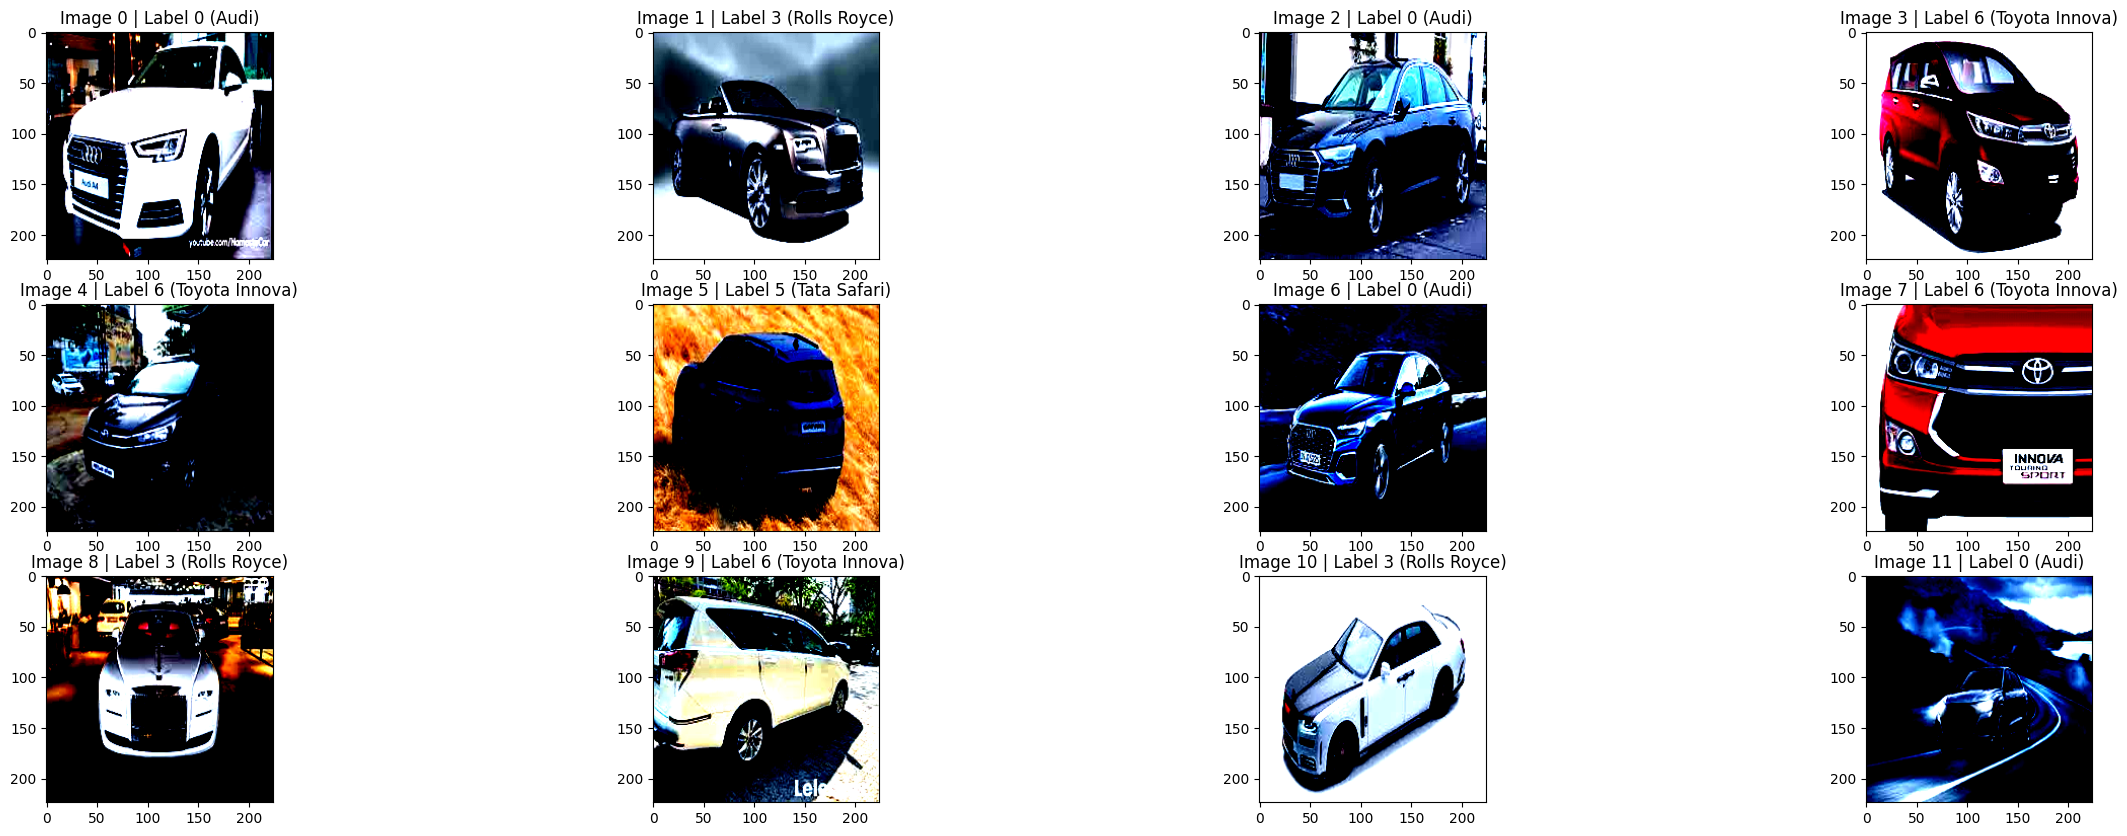

In [18]:
data_generator.visualize()

### Model, loader, optimizer, criterion and scheduler definition

In [19]:
class RESNET50(torch.nn.Module):

    def __init__(self, pretrained = True, freeze = True, verbose = True):
        super().__init__()
        self.resnet50 = models.resnet50(weights='ResNet50_Weights.DEFAULT')
        if freeze:
            for params in self.resnet50.parameters():
                params.requires_grad = False
        self.resnet50.fc = nn.Linear(in_features=self.resnet50.fc.in_features, out_features=len(CLASSES_TO_INT))
        if verbose:
            print(self.resnet50)
    
    def forward(self, x):
        return self.resnet50(x)

model = RESNET50(freeze=False)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
DEVICE = torch.device("mps") # "cpu" otherwise
model.to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
train_loader, test_loader = data_generator.get_data_loaders()
criterion = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS.to(DEVICE))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

### Training and testing

In [21]:
class Fit:

    def __init__(self, 
                 model, 
                 train_loader, 
                 test_loader,
                 optimizer, 
                 criterion, 
                 scheduler, 
                 epochs, 
                 device,
                 save_model = True,
                 save_path_dir = None, 
                 model_name = "car_model_", 
                 verbose = True, 
                 verbose_step = 50):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.epochs = epochs
        self.device = device
        self.save_model = save_model
        self.save_path_dir = save_path_dir
        self.model_name = model_name
        self.verbose = verbose
        self.verbose_step = verbose_step
        self.start_epoch = 0
        self.train_loss = []
        self.test_loss = []
        self.train_step_loss = {"x": [], "y": []}
        self.best_test_loss = np.inf
        self.best_model = copy.deepcopy(self.model)
        self.save_path = self.save_path_dir + self.model_name + ''.join(random.choices(string.ascii_uppercase + string.digits, k = 10)) + '.pth'
        
    def save(self, model):
        model.to("cpu")
        torch.save({
            'epoch': self.epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            }, self.save_path)
        print(f"Model saved to -> {self.save_path}")
        model.to(self.device)
    
    def plot_loss_curve(self, x_label='Epochs'):
        epochs = range(1, len(self.train_loss)+1)
        plt.plot(epochs, self.train_loss, 'g', label='Training loss')
        plt.plot(epochs, self.train_loss, 'g*', label='Training loss spots')
        plt.plot(epochs, self.test_loss, 'r', label='Test loss')
        plt.plot(epochs, self.test_loss, 'r*', label='Test loss spots')
        plt.title('Training and testing Loss')
        plt.xlabel(x_label)
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    
    def plot_step_loss_curve(self, x_label='Step Loss x1000'):
        if self.train_step_loss["x"] and self.train_step_loss["y"]:
            plt.plot(self.train_step_loss["x"], self.train_step_loss["y"], 'b', label='Training step loss')
            plt.title('Training Step Loss')
            plt.xlabel(x_label)
            plt.ylabel('Step Loss')
            plt.legend()
            plt.show()
    
    def fit(self):
        print(f"\nDEVICE - {self.device} || EPOCHS - {self.epochs} || LEARNING RATE - {self.optimizer.param_groups[0]['lr']}.\n")
        step_size = 0
        for epoch in range(self.start_epoch, self.epochs):
            # Train phase
            self.model.train()
            start_epoch_time = time.time()
            if self.verbose:
                _start_at = datetime.now().strftime('%H:%M:%S %d|%m|%Y')
                _lr = self.optimizer.param_groups[0]['lr']
                print(f'\nEPOCH - {epoch+1}/{self.epochs} || START AT - {_start_at} || LEARNING RATE - {_lr}\n')
            running_loss, step_running_loss = 0, 0
            start_step_time = time.time()
            for step, (images, labels) in enumerate(self.train_loader):
                step_size += images.size(0)
                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                output = self.model(images)
                loss = self.criterion(output, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
                step_running_loss += loss.item()
                if self.verbose:
                    if (step+1) % self.verbose_step == 0:
                        print(
                                f'\tTrain Step - {step+1}/{len(self.train_loader)} | ' + \
                                f'Train Step Loss: {(step_running_loss/self.verbose_step):.5f} | ' + \
                                f'Time: {(time.time() - start_step_time):.2f}s.\n'
                            )
                        self.train_step_loss["x"].append(step_size/1000)
                        self.train_step_loss["y"].append(step_running_loss/self.verbose_step)
                        step_running_loss = 0   
                        start_step_time = time.time()
            self.train_loss.append(running_loss/len(self.train_loader))
            self.scheduler.step(running_loss/len(self.train_loader))
            if self.verbose:
                print(f'\tEPOCH - {epoch+1}/{self.epochs} || TRAIN LOSS - {(running_loss/len(self.train_loader)):.5f} || TIME ELAPSED - {(time.time() - start_epoch_time):.2f}s.\n')
            # Test Phase
            start_epoch_test_time = time.time()
            self.model.eval()
            running_test_loss, step_running_test_loss = 0, 0
            for step, (test_images, test_labels) in enumerate(self.test_loader):
                test_images, test_labels = test_images.to(self.device), test_labels.to(self.device)
                test_output = self.model(test_images)
                test_loss = self.criterion(test_output, test_labels)
                running_test_loss += test_loss.item()
            if self.verbose:
                print(f'\tEPOCH - {epoch+1}/{self.epochs} || TEST LOSS - {(running_test_loss/len(self.test_loader)):.5f} || TIME ELAPSED - {(time.time() - start_epoch_test_time):.2f}s.\n')
            self.test_loss.append(running_test_loss/len(self.test_loader))
            if self.best_test_loss > running_test_loss:
                self.best_test_loss = running_test_loss
                self.best_model = copy.deepcopy(self.model)
        if self.verbose:
            self.plot_loss_curve()
            self.plot_step_loss_curve()
        if self.save_model:
            self.save(model=self.best_model)
        return self.model.to("cpu"), self.best_model.to("cpu")
    
    def test(self):
        print("Testing model...")
        self.best_model.eval()
        self.best_model.to("cpu")
        y, y_hat = [], []
        for step, (test_images, test_labels) in enumerate(self.test_loader):
            test_images, test_labels = test_images.to("cpu"), test_labels.to("cpu")
            test_output = self.model(test_images)
            test_output = np.argmax(test_output.detach().numpy(), axis=1)
            test_labels = test_labels.detach().numpy()
            for _ in range(test_output.shape[0]):
                y.append(test_labels[_])
                y_hat.append(test_output[_])
        print(classification_report(y, y_hat, target_names=CLASSES_TO_INT.keys()))


DEVICE - mps || EPOCHS - 25 || LEARNING RATE - 0.001.


EPOCH - 1/25 || START AT - 09:02:05 16|06|2023 || LEARNING RATE - 0.001

	EPOCH - 1/25 || TRAIN LOSS - 1.53913 || TIME ELAPSED - 42.84s.

	EPOCH - 1/25 || TEST LOSS - 1.29112 || TIME ELAPSED - 4.34s.


EPOCH - 2/25 || START AT - 09:02:52 16|06|2023 || LEARNING RATE - 0.001

	EPOCH - 2/25 || TRAIN LOSS - 1.08755 || TIME ELAPSED - 42.56s.

	EPOCH - 2/25 || TEST LOSS - 0.88985 || TIME ELAPSED - 4.19s.


EPOCH - 3/25 || START AT - 09:03:39 16|06|2023 || LEARNING RATE - 0.001

	EPOCH - 3/25 || TRAIN LOSS - 0.71528 || TIME ELAPSED - 42.41s.

	EPOCH - 3/25 || TEST LOSS - 0.63320 || TIME ELAPSED - 4.21s.


EPOCH - 4/25 || START AT - 09:04:25 16|06|2023 || LEARNING RATE - 0.001

	EPOCH - 4/25 || TRAIN LOSS - 0.46720 || TIME ELAPSED - 42.50s.

	EPOCH - 4/25 || TEST LOSS - 0.48971 || TIME ELAPSED - 4.25s.


EPOCH - 5/25 || START AT - 09:05:12 16|06|2023 || LEARNING RATE - 0.001

	EPOCH - 5/25 || TRAIN LOSS - 0.31324 || TIME ELAPSED - 42.32s

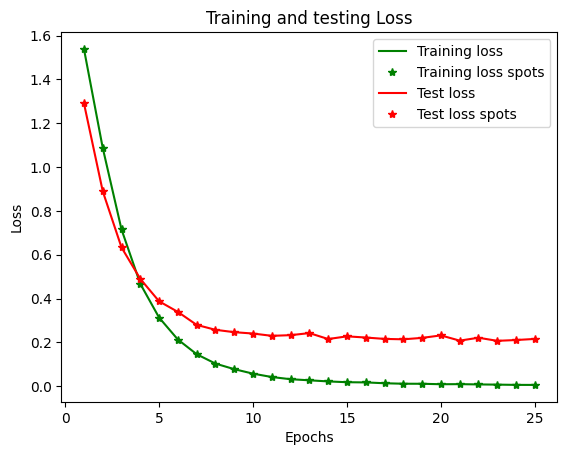

Model saved to -> ./model/car_model_FND4MV4G0D.pth


In [22]:
trainer = Fit(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    epochs=25,
    device=DEVICE,
    save_path_dir="./model/",
    verbose=True,
    verbose_step=500
)
trained_model, best_trained_model = trainer.fit()

In [23]:
trainer.test()

Testing model...
                  precision    recall  f1-score   support

            Audi       0.91      0.93      0.92       199
   Hyundai Creta       0.79      0.82      0.80        67
Mahindra Scorpio       0.96      0.89      0.92        75
     Rolls Royce       0.88      0.69      0.77        74
           Swift       0.96      0.93      0.95       102
     Tata Safari       0.89      0.96      0.93       106
   Toyota Innova       0.93      0.97      0.95       190

        accuracy                           0.91       813
       macro avg       0.90      0.89      0.89       813
    weighted avg       0.91      0.91      0.91       813



### Predict

In [25]:
saved_model_path = "./model/car_model_FND4MV4G0D.pth"
ckpt = torch.load(saved_model_path)
predict_model = RESNET50(verbose=False)
predict_model.load_state_dict(ckpt['model_state_dict'])
predict_model.to("cpu")

RESNET50(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [26]:
def predict(image_path, label, model):
    # Read image
    image = Image.open(image_path).convert("RGB")
    # Resize
    resize_height, resize_width = RESIZE
    resized_image = np.asarray(image.resize((resize_width, resize_height)))
    # Normalize
    mean = (0.485, 0.456, 0.406)
    variance = (0.229, 0.224, 0.225)
    resized_image = resized_image - np.array([mean[0]*255, mean[1]*255, mean[2]*255], dtype=np.float32)
    resized_image = resized_image / np.array([variance[0]*255, variance[1]*255, variance[2]*255], dtype=np.float32)
    normlaized_image = np.clip(resized_image, 0, 1).astype(np.float32)
    image_tensor = torch.unsqueeze(torch.permute(torch.from_numpy(normlaized_image).type(torch.float32), (2, 0, 1)), 0)
    output = model(image_tensor)
    output = np.argmax(output.detach().numpy())
    plt.imshow(image)
    plt.title(f"Predicted class: {INT_TO_CLASSES[output]} | Actual class: {INT_TO_CLASSES[label]}")

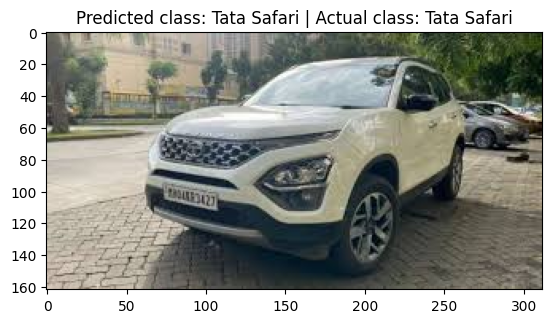

In [33]:
idx = random.choice(np.arange(0, len(test_loader)))
record = test_df.iloc[idx]
predict(record.image, record.label, predict_model)